# Dataset Generation

In this Jupyter Notebook, we will generate a dataset for subsequent training purposes. The dataset will be created using 20 different fonts, each containing images of the letters **'a' to 'z'**. To enhance the diversity of the dataset, various image transformations will be applied to the original images. These transformations include:

- **Gaussian Blur**: This filter will apply a Gaussian function to blur the images, helping to simulate various levels of out-of-focus scenarios.
- **Motion Blur**: This filter will simulate the effect of camera motion, creating the appearance of movement within the image.
- **Zoom**: This transformation will adjust the scale of the images to simulate zooming in and out, which can help the model handle variations in size.
- **Rotation**: This filter will rotate the images at different angles to introduce orientation variability, aiding the model in recognizing letters regardless of their rotation.

By applying these filters, we aim to create a more robust and comprehensive dataset that will aid in improving the performance and generalizability of the model during training.

In [2]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 14.3 MB/s eta 0:00:0000:0100:01


In [19]:
import pandas as pd
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import os
import tensorflow
import os
import random

In [20]:
# Helper Class to show easily Pictures
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

## Image Creation and Maniplulation

In [21]:
def create_image_with_text(
    text='A',
    font_path="", 
    width=40, 
    height=40, 
    thickness=1, 
):
    image = np.ones((height, width), dtype=np.uint8) * 255 
    font_size = 30  # Set Font Size
    font = ImageFont.truetype(font_path, font_size)
    
    # Convert to PIL Format
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)
    
    text_width = font.getlength(text)
    text_height = font_size
    
    # Center Image
    text_x = (width - text_width) // 2 
    text_y = (height - text_height) // 2
    
    for i in range(-thickness, thickness + 1):
        for j in range(-thickness, thickness + 1):
            draw.text((text_x + i, text_y + j), text, font=font, fill=0)
    
    # Convert Image to OpenCV
    image = np.array(pil_image)
    return image

In [22]:
def perspective_transformation(image, width, height, zoom_factor):
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    
    zoomed_width = int(width * zoom_factor)
    zoomed_height = int(height * zoom_factor)
    
    pts2 = np.float32([
        [random.randint(-zoomed_width // 4, zoomed_width // 4), random.randint(-zoomed_height // 4, zoomed_height // 4)],
        [zoomed_width - random.randint(-zoomed_width // 4, zoomed_width // 4), random.randint(-zoomed_height // 4, zoomed_height // 4)],
        [random.randint(-zoomed_width // 4, zoomed_width // 4), zoomed_height - random.randint(-zoomed_height // 4, zoomed_height // 4)],
        [zoomed_width - random.randint(-zoomed_width // 4, zoomed_width // 4), zoomed_height - random.randint(-zoomed_height // 4, zoomed_height // 4)]
    ])
    
    M = cv2.getPerspectiveTransform(pts1, pts2)
    image = cv2.warpPerspective(image, M, (zoomed_width, zoomed_height))
    
    return image


In [23]:
def rotate_image(image, angle=30):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rot = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image,
                             rot,
                             (w, h),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=255)
    return rotated  

In [24]:
def gaussian_noise(image, mean=0, stddev=2):
    gaussian_noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, gaussian_noise)
    return noisy_image

In [25]:
def add_blur(image, ksize=(3, 3)):
    blurred_image = cv2.GaussianBlur(image, ksize, 0)
    return blurred_image

In [29]:
def get_font_list(path='Font'):
    font_list = {}
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith('.ttf'):
                full_path = os.path.join(root, file)
                key = os.path.splitext(file)[0]
                font_list[key] = full_path
    return font_list    

## Prepare Dataset

In [30]:
blur_limit = (1, 3)
gaussian_limit = (0, 2)
rotation_limit = (-10, 10)
breite_limit = (0, 1)
alphabet_list = [chr(i) for i in range(ord('a'), ord('z') + 1)]
zoom_factor = [1]
font_list = get_font_list()

In [31]:
index = 0
for letter in alphabet_list:
    for font in font_list.keys():
        os.makedirs(f'Dataset/{font}/{letter}', exist_ok=True)
        for breite in range(breite_limit[0], breite_limit[1]):
            img = create_image_with_text(text=letter,font_path=font_list[font], thickness=breite)
            for rotation in range(rotation_limit[0], rotation_limit[1], 1):
                rot_img = rotate_image(img, angle=rotation)
                for gaussian in range(gaussian_limit[0], gaussian_limit[1]):
                    gaus_img = gaussian_noise(rot_img, stddev=gaussian)
                    for blur_id in range(blur_limit[0], blur_limit[1], 2):
                        blur_img = add_blur(gaus_img, (blur_id, blur_id))
                        cv2.imwrite(f'Dataset/{font}/{letter}/{index}.png', blur_img)
                        index +=1
                        height, width = blur_img.shape[:2]
                        persp_img = perspective_transformation(blur_img, width, height, 1)
                        cv2.imwrite(f'Dataset/{font}/{letter}/{index}.png', persp_img)
                        index +=1

## Display Example Letters of 'a'

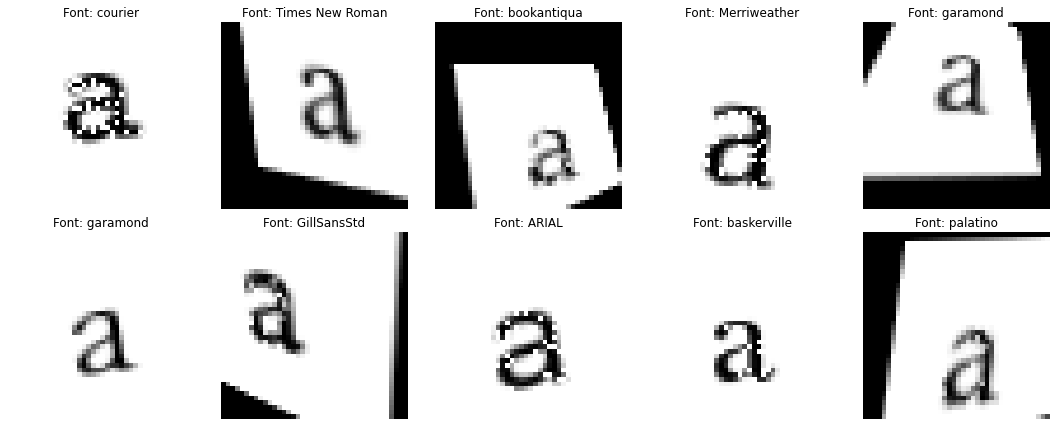

In [32]:
def get_image_paths(letter):
    image_paths = []
    for font in os.listdir('Dataset'):
        letter_dir = os.path.join('Dataset', font, letter)
        if os.path.exists(letter_dir):
            for img_file in os.listdir(letter_dir):
                if img_file.endswith('.png'):
                    image_paths.append(os.path.join(letter_dir, img_file))
    return image_paths

a_image_paths = get_image_paths('a')

selected_images = random.sample(a_image_paths, min(10, len(a_image_paths)))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    if i < len(selected_images):
        img = cv2.imread(selected_images[i], cv2.IMREAD_GRAYSCALE)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Font: {os.path.basename(os.path.dirname(os.path.dirname(selected_images[i])))}")
    else:
        ax.remove()

plt.tight_layout()
plt.show()